# DLA homework II. KWS model
*Project was accomplished by Andrey Borevsky*

----

## Ist part. Seminar prerequisites

>In this section we mostly construct our future working process via importing external and internal code materials. The former was taken almost in pure form from the seminar. However, the latter was mostly produced by the author based on particular materials devoted to the implemented algorithms. 

### 1. External libraries

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import logging

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
import warnings 
import random
import os
warnings.filterwarnings('ignore')

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
import logging.config
from thop import profile

### 2. Seminar prerequisites

In [2]:
from seminar import count_FA_FR, get_au_fa_fr, get_size_in_megabytes
from seminar import SpeechCommandDataset, AugsCreation, get_sampler, Collator
from seminar import LogMelspec, TaskConfig

### 3. Introduced materials

In [793]:
from utils import set_random_seed, seed_everything, read_json, create_log

### 4. Pipeline establishment

> Let's firstly create a dataset following the seminar's architecture. We also want to fix the seed in order to ensure the reproducibility.

In [4]:
set_random_seed(0)

dataset = SpeechCommandDataset(path2dir='speech_commands', keywords=TaskConfig.keyword)

> Next, we create training and validation dataframes, further transmitted to the dataset class itself.

In [5]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

> Then, Dataloaders structure of torch library is introduced with a help of seminar's get_sampler method.

In [7]:
train_sampler = get_sampler(train_set.csv['label'].values)

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(), pin_memory=True)

> Also, it is vital to define two separate classes, transforming sound waves to spectrograms of values' logarithms. While the training LogMelspec implements certain transformations, the validation one does not.

In [8]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

## IInd part. CRNN structure & Train functions

### 1. Appearance of model

> It seems rational to give a brief review of prime CRNN model's renewals. So, first to start is, of course, the introduction of separate "script story". It is marked by flag `self.qat` and generally designed for the Quantization-Aware Training embodiement withing the created network. The script itself contains Quant-Dequant pair, responsible for turning quantization on and off respectively. Also there is a special `qconfig` attribute, standing fpr quantization configuration, required for the `torch.quantization` library. We have also separated convolutional layer and flattening module in order to make a chain: Quant - Conv - ReLU - Dequant - Flatten.

> Another point to be added clarifies `mode` flag. Basically, there are three potential scripts:
>    1. **'base'** - a base/teacher model
>    
>    2. **'rnn'**  - a student model, using RNN and expanding it for KD
>    
>    3. **'gru'**  -  a student model, using GRU (as in seminar's code) and expanding it for KD
>
>    4.**'light** - a student model, using GRU
> In case of not base mode, we must introduce auxillary fully-connected layers for synchronization of teacher's and student's output tensors' shapes.

> Considering the QAT script, we have added several `if` options within the `forward` method. We also basically return three tensors: output of gru / rnn, output of attention and resulting output. It also important to underscore the fact that we use double expanding of student's tensor in case of **'rnn'** method. Since both dimensions do not coincide after `GRU` / `RNN` because of convolution, it is the most practical step found. Sure, all the additional 'expanding' layers are removed for final assessment and are not presented in KWS class instance.

In [708]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig, mode='base', qat=False):
        super().__init__()
        self.config = config
        self.mode = mode
        self.qat = qat
        
        if self.qat:
            self.quant = torch.quantization.QuantStub()
            self.activation = nn.ReLU()
            self.qconfig = None

        self.conv = torch.nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            )
        
        if self.qat:
            self.dequant = torch.quantization.DeQuantStub()
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=2)

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        if self.mode == 'rnn':
            self.gru = nn.RNN(
                input_size=self.conv_out_frequency * config.cnn_out_channels,
                hidden_size=config.hidden_size,
                num_layers=config.gru_num_layers,
                dropout=0.1,
                bidirectional=config.bidirectional,
                batch_first=True
            )
            
        else:
            self.gru = nn.GRU(
                input_size=self.conv_out_frequency * config.cnn_out_channels,
                hidden_size=config.hidden_size,
                num_layers=config.gru_num_layers,
                dropout=0.1,
                bidirectional=config.bidirectional,
                batch_first=True
            )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
        
        if self.mode != 'base': 
            self.equalizer = nn.Linear(config.hidden_size, 32)
            if self.mode != 'light': 
                self.equalizer_rnn_1 = nn.Linear(config.hidden_size, 32)
                self.equalizer_rnn_2 = nn.Linear(7, 11)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        if self.qat: 
            input = self.quant(input)
        conv_output = self.conv(input)
        if self.qat:
            conv_output = self.dequant(self.activation(conv_output))
        flat_output = self.flatten(conv_output).transpose(-1, -2)
        gru_output, _ = self.gru(flat_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        if self.mode != 'base' and self.training:
            contex_vector = self.equalizer(contex_vector)
            if self.mode != 'light':
                gru_output = self.equalizer_rnn_1(gru_output)
                gru_output = self.equalizer_rnn_2(gru_output.transpose(1, 2)).transpose(1, 2)
            return output, contex_vector, gru_output
        return output


### 2. Training path

> `train` - this is a new brand new function for the seminar learner, but is was initially similar to the train loop within the explored notebook. Now, we have a special function `make_qat`, being called at the first steps only in case if `model.qat` flag is positive. What it does is simply introducing QAT observers on all layers between Quant and Dequant, described earlier. After such a nice foreplay, we meet the core of our function, which is mostly identical to its ancestor in the key steps: `train_epoch` - `validation` - `graphs`. However, there is a slight difference, again having roots in the QAT case. If model's flag is up, then we need to apply a special convert function to step from `torch.float32` to `torch.qint8`.

>`train_epoch` is familar to us from seminar's notebook. It has preserved its core objectives. At the same time, there is a number of modifications. First of all, we now collect three values from the model (output, attention, rnn). Then our scripts diversify with accordance to `mode` parameter:
>
>    1.**'base'** - we cool, simple training loop as if we worked with initial code (cannot be used with other modes).
>
>    2.**'dark kd'** - we implement a KD for the models' outputs. 
>
>    3.**'attention'** - we implement a KD for the attention layers' outputs. 
>
>    4.**'gru'** - we implement a KD for the rnn layers' outputs. 
>
> Last to add here is that teachers' outputs are calculated only in case if `mode != 'base`. Also, each KD case implies a dict of hyperparameters (temperature and alpha). We have additionally introduced double scheduler scheme, where the first is updated each iteration and another - each epoch. The threshold is given explicitly.

>We finally reached end of the path - `validation` function. Here might be performed another great tool of compression at the very beginning of the call. What we mean is dynamic quantization. It is applied for all layers except the convolutional and the expanding ones. There are two options: convert to `torch.float16` & `torch.qint8`. The choice is made according to the provided hyperparameter. As quantization passed, the rest of the code is resemble to the origins.

In [437]:
def train_epoch(model, opt, loader, log_melspec, device, 
                scheduler=None, mode={'base': None}, bm=None, n_epoch=None):
    model.train()
    accs = []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        loss = 0
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits, attention, rnn = model(batch)
        probs = F.softmax(logits, dim=-1)
        
        if 'base' in mode.keys():
            loss = F.cross_entropy(logits, labels)
        else:
            with torch.no_grad(): 
                teacher_logits, teacher_attention, teacher_rnn = bm(batch)
            if 'attention' in mode.keys():   
                T = mode['attention']['T']
                alpha = mode['attention']['alpha']
                loss += nn.KLDivLoss()(F.softmax(attention/T, dim=-1),
                                       F.softmax(teacher_attention/T, dim=-1)) * (alpha * T * T)
            if 'gru' in mode.keys():   
                T = mode['gru']['T']
                alpha = mode['gru']['alpha']
                loss += nn.KLDivLoss()(F.softmax(rnn/T, dim=-1),
                                       F.softmax(teacher_rnn/T, dim=-1)) * (alpha * T * T)
            if 'dark kd' in mode.keys():
                T = mode['dark kd']['T']
                alpha = mode['dark kd']['alpha']
                loss += nn.KLDivLoss()(F.softmax(logits/T, dim=-1),
                                       F.softmax(teacher_logits/T, dim=-1)) * (alpha * T * T) + \
                                       F.cross_entropy(logits, labels) * (1. - alpha)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        if scheduler is not None and n_epoch <= scheduler[2]:
            scheduler[0].step()

        opt.step()

        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        FA, FR = count_FA_FR(argmax_probs, labels)
        accs.append((torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)).item())
        
    return np.mean(accs)

In [803]:
@torch.no_grad()
def validation(model, loader, log_melspec, device, mode={'base': None}):
    model.eval()
    if 'post_quant' in mode.keys():
        qconfig = torch.quantization.per_channel_dynamic_qconfig
        qconfig_dict = dict.fromkeys(['attention', 'classifier', 'gru'], qconfig)
        if mode['post_quant']['dtype'] == 8:
            val_model = torch.quantization.quantize_dynamic(model, qconfig_spec=qconfig_dict, 
                                                            dtype=torch.quint8)
        elif mode['post_quant']['dtype'] == 16:
            val_model = torch.quantization.quantize_dynamic(model, qconfig_spec=qconfig_dict,
                                                            dtype=torch.float16)
    else:
        val_model = model

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = val_model(batch)

        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)


        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [514]:
def make_qat(model):
    qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    #model = torch.quantization.fuse_modules(model, [['conv', 'activation']])
    model.qconfig = qconfig
    model.attention.qconfig = None
    model.gru.qconfig = None
    model.classifier.qconfig = None
    if hasattr(model, 'equalizer'): model.equalizer.qconfig = None
    if hasattr(model, 'equalizer_rnn_1'):
        model.equalizer_rnn_1.qconfig = None
        model.equalizer_rnn_2.qconfig = None
    torch.quantization.prepare_qat(model, inplace=True)

def train(model, opt, config, epochs, history, logger, bm=None, scheduler=None, mode={'base':None}):
    
    if model.qat:
        make_qat(model)
        logger.info('Quantization Aware training enabled')
        
    start = time.time()
    val_model = None
    for n in range(epochs):
        history['lrs'].append(opt.param_groups[0]['lr'])
        logger.info('Epoch {0} starts'.format(n+1))
        acc = train_epoch(model, opt, train_loader,
                    melspec_train, config.device, scheduler, mode, bm, n_epoch=n)
        if model.qat:
            val_model = torch.quantization.convert(model, inplace=False)
        else:
            val_model = model
        
        au_fa_fr = validation(val_model, val_loader,
                              melspec_val, base_config.device, mode)
        clear_output()
        if scheduler is not None and epochs > scheduler[2]:
            scheduler[1].step(au_fa_fr)
        history['val_metric'].append(au_fa_fr)
        history['acc'].append(acc)
        
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.title('After {0} epochs'.format(n+1))
        plt.grid()
        plt.show()
        plt.plot(history['lrs'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.title('After {0} epochs'.format(n+1))
        plt.grid()
        plt.show()
        logger.info('Metric value {0}'.format(np.round(au_fa_fr, 6)))
        if au_fa_fr <= 5.5e-5: break
    logger.info('Training has been accomplished for {0} minutes'.format(np.round((time.time() - start) / 60, 2)))
    return val_model

## IIIrd part. Teacher

### 1. Base model initialization

> Here everything looks like a repetition of steps from seminar with little inconsistence: we've added logger as we would do in all following experiments.

In [47]:
base_history = defaultdict(list)
log_dict = {'json' : 'logger_config.json', 'name' : 'base_model_qat'}
base_logger = create_log(log_dict)
base_config = TaskConfig(hidden_size=32)
base_model = CRNN(base_config, qat=False).to(base_config.device)

print(base_model)

CRNN(
  (conv): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [48]:
mode = {'base':None}

opt = torch.optim.Adam(
    base_model.parameters(),
    lr=base_config.learning_rate,
    weight_decay=base_config.weight_decay
)

print('Base model № of parameters:', sum([p.numel() for p in base_model.parameters()]))

Base model № of parameters: 25387


> This part appears already to be a shadow of past since `base_model` was once trained for a required quality and preserved as it is.

In [ ]:
#train(base_model, opt, base_config, TaskConfig.num_epochs, base_history, base_logger, scheduler=None, mode=mode)

> Here we reach an essential ramification of scripts: one goes for a classic `base_model` (2nd) and another for `base_model_qat`, meaning teacher, who also implements qauntization aware training for a better coherence with experiments impling QAT.

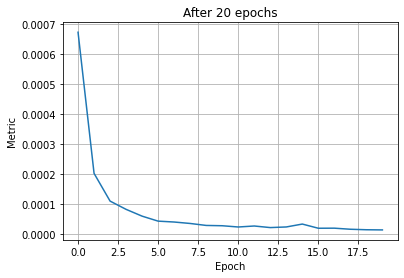

In [137]:
base_model_qat = CRNN(base_config, qat=True).to(base_config.device)
train(base_model_qat, opt, base_config, 0, base_history, base_logger, scheduler=None, mode=mode)
base_model_qat.load_state_dict(torch.load('base_model_qat'))
print('Base model loss', validation(base_model_qat, val_loader, melspec_val, base_config.device))

Quantization Aware training enabled
Training has been accomplished for 0.0 minutes


<All keys matched successfully>

In [49]:
base_model_qat = torch.jit.load('base_model_qat.pt')
base_model_qat.eval()

RecursiveScriptModule(
  original_name=CRNN
  (quant): RecursiveScriptModule(original_name=QuantStub)
  (activation): RecursiveScriptModule(original_name=ReLU)
  (conv): RecursiveScriptModule(original_name=Conv2d)
  (dequant): RecursiveScriptModule(original_name=DeQuantStub)
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (gru): RecursiveScriptModule(original_name=GRU)
  (attention): RecursiveScriptModule(
    original_name=Attention
    (energy): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=Tanh)
      (2): RecursiveScriptModule(original_name=Linear)
    )
  )
  (classifier): RecursiveScriptModule(original_name=Linear)
)

In [478]:
print('Base model loss', validation(base_model_qat, val_loader, melspec_val, base_config.device))

100%|█████████████████████████████████████████| 102/102 [00:34<00:00,  2.98it/s]


Base model loss 1.5288856902833853e-05


In [333]:
template = torch.load('bbm', map_location=torch.device('cpu'))

base_model = CRNN(base_config).to(base_config.device)
base_model.load_state_dict(template)

base_model.eval()

CRNN(
  (conv): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [334]:
print('Base model loss', validation(base_model, val_loader, melspec_val, base_config.device))

100%|█████████████████████████████████████████| 102/102 [00:35<00:00,  2.90it/s]


Base model loss 5.440016374950562e-05


# Speed & Compression

## IVth part. Experiment "Low and Everything"

>Idea, standing beyond the concept of this experiment, was quite straightforward: choose supreme tools after checking among all the suggested and combine them with low start (by number of parameters) student model. Of course, after several runs it was understood that the quality of teacher model should be as high as possible (strongly below 5e-5) in order to bolster the student.
>
> We present here a separate logger object named 'experiment one', `mode` dictionary, containing:
>
> 1. **Dark KD**: temperature 10, alpha 0.75
> 2. **Attention KD**: temperature 10, alpha 0.45
> 3. **Dynamic quantization**: qint8
> 4. **QAT** comes from the model initialization
>
> Optimizer is set to Adam with starting learning rate eqial to 1e-3, while a pair of schedulers is also introduced (where the first is turned off by the threshold).

In [728]:
quality_flops = []
quality_mem = []

In [607]:
config = TaskConfig(hidden_size=18, cnn_out_channels=4, kernel_size=(7, 18), stride=(5, 12), gru_num_layers=1)
model = CRNN(config, mode='gru', qat=True).to(config.device)

exp_log_dict = {'json' : 'logger_config.json', 'name' : 'experiment_one'}
exp_logger = create_log(exp_log_dict)

exp_logger.info('Experiment model: {0}'.format(model))

Experiment model: CRNN(
  (quant): QuantStub()
  (activation): ReLU()
  (conv): Conv2d(1, 4, kernel_size=(7, 18), stride=(5, 12))
  (dequant): DeQuantStub()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(28, 18, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=18, out_features=18, bias=True)
      (1): Tanh()
      (2): Linear(in_features=18, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=18, out_features=2, bias=True)
  (equalizer): Linear(in_features=18, out_features=32, bias=True)
  (equalizer_rnn_1): Linear(in_features=18, out_features=32, bias=True)
  (equalizer_rnn_2): Linear(in_features=7, out_features=11, bias=True)
)


In [609]:
opt = torch.optim.Adam(
    model.parameters(),
    lr=0.0007,
    weight_decay=config.weight_decay
)

mode = {
    'dark kd'   : {'T' : 10, 'alpha' : 0.75}, 
    'attention' : {'T' : 10, 'alpha' : 0.45},
    'post_quant': {'dtype' : 8}
}
history = defaultdict(list)

> We must assess the **speed rate** before the experiment starts since quantization will severly reduce № of operations with floating point, while still the calculations will be held. By the way, the same reason will force us to assess **compression rate** after training and validations steps.

In [606]:
item = melspec_train(next(iter(train_loader))[0])
model.mode = 'base'
attempt = profile(model, (item, ))
baseline = profile(base_model, (item, ))
clear_output()
print('Model', attempt)
print('Base Model', baseline)
print('Ratio', baseline[0] / attempt[0])

Model (5907456.0, 3499.0)
Base Model (55382016.0, 25387.0)
Ratio 9.374934997399896


> **Run !**

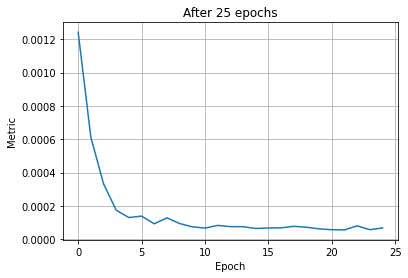

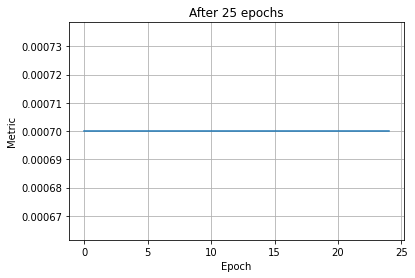

Metric value 6.8e-05
Training has been accomplished for 73.52 minutes


In [610]:
scheduler_two = lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.8, patience=0, min_lr=0.0002)
scheduler_one = lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0.0005)

val_model = train(model, opt, config, 25, history, exp_logger, base_model_qat, 
                  None, mode)

> It seems that the quality of the model is not identical to the one announced (4.57e-5). This due to the following reason: during the notebook check, it was found that logging from this experiment was accidentally lost. Therefore, we  have re-ran the code at some optimizer hyperparameters, close to those used before. If check the logs, we can see that the following model has almost beat the benchmark. Consequently, we just wanted to fix the training time & prove we really elaborated an efficient approach. In case of required provement, we can provide original commit, whice gave us the saved model.

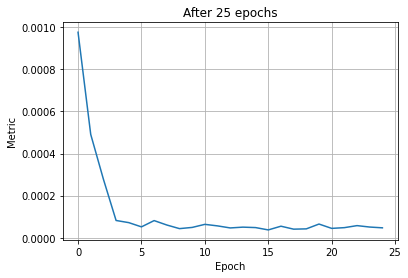

> The code is reproducible. But we have saved our initial model from this experiment in both dictionary and jit formats. Let's upload the former, convert it via both QAT and dynamic quantization and measure the resulting quality if it is below the benchmark. IF there is a little suspicion, we can always compare announced models' hyperparameters above, which are used in FLOPs calculation, and the uploaded model's architecture.

In [611]:
ttt = copy.deepcopy(model)

In [632]:
model = CRNN(config, mode='light', qat=True).to(config.device)

mode = {
    'dark kd'   : {'T' : 10, 'alpha' : 0.75}, 
    'attention' : {'T' : 10, 'alpha' : 0.45},
    'post_quant': {'dtype' : 8}
}
train(model, opt, config, 0, history, exp_logger, base_model, 
      [None, None, -1], mode)
clear_output()


model.load_state_dict(torch.load('small_work_exp'))
model.equalizer.weight = nn.Parameter(torch.empty((1, 1)))
model.equalizer.bias = nn.Parameter(torch.empty((1)))

val_model = torch.quantization.convert(model, inplace=False)
qconfig = torch.quantization.per_channel_dynamic_qconfig
qconfig_dict = dict.fromkeys(['attention', nn.Linear, nn.GRU], qconfig)
val_model = torch.quantization.quantize_dynamic(val_model,
                                                    dtype=torch.qint8)
val_model.half()

val_model

CRNN(
  (quant): Quantize(scale=tensor([0.2312], dtype=torch.float16), zero_point=tensor([90]), dtype=torch.quint8)
  (activation): ReLU()
  (conv): QuantizedConv2d(1, 4, kernel_size=(7, 18), stride=(5, 12), scale=1.7637978792190552, zero_point=76)
  (dequant): DeQuantize()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): DynamicQuantizedGRU(28, 18, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=18, out_features=18, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=18, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=18, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (equalizer): DynamicQuantizedLinear(in_features=18, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [40]:
print('Quality', validation(val_model.half(), val_loader, melspec_val, base_config.device, {'base':None}))

100%|█████████████████████████████████████████| 102/102 [00:34<00:00,  2.94it/s]


Quality 4.5759154852041366e-05


> Finally, we can see our mark for **compression rate** in this experiment. We want to once more repeat the fact that the size of `model.equalizer` is not taken into account since it will be not presented in KWS and can be for sure removed if we'd make a wrapper for validation only.

In [633]:
import tempfile
get_size_in_megabytes(base_model) / (get_size_in_megabytes(val_model))

8.259800563294512

In [729]:
quality_flops.append((4.58e-5, 9.37))
quality_mem.append((4.58e-5, 8.26))

## Vth part. Experiment "Stupid student, Smart teacher"

> Here we thought of making an attempt to optimize the core issue of our teacher in terms of parameters: **GRU**. By changing it to classic **RNN**, we have immediately jumped down in number of operations. Therefore, we increased some model's hyperparameters compared to exp 1, trying to enhance model as an exchange for the first alteration.

In [808]:
config = TaskConfig(hidden_size=29, cnn_out_channels=4, kernel_size=(7, 18), stride=(5, 12), gru_num_layers=1)
model = CRNN(config, mode='base', qat=True).to(config.device)

exp_log_dict = {'json' : 'logger_config.json', 'name' : 'experiment_two'}
exp_logger = create_log(exp_log_dict)

exp_logger.info('Experiment model: {0}'.format(model))

Experiment model: CRNN(
  (quant): QuantStub()
  (activation): ReLU()
  (conv): Conv2d(1, 4, kernel_size=(7, 18), stride=(5, 12))
  (dequant): DeQuantStub()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(28, 29, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=29, out_features=29, bias=True)
      (1): Tanh()
      (2): Linear(in_features=29, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=29, out_features=2, bias=True)
)


> Here we switch modes of the model in order to remove equalizers from the training path and, thus, calculate true **speed rate** of the current student model.

In [494]:
item = melspec_train(next(iter(train_loader))[0])
tmp = copy.deepcopy(model)
tmp.mode = 'base'
attempt = profile(tmp, (item, ))
baseline = profile(base_model, (item, ))
clear_output()
print('Model', attempt)
print('Base Model', baseline)
print('Ratio', baseline[0] / attempt[0])

Model (5507072.0, 3179.0)
Base Model (55382016.0, 25387.0)
Ratio 10.056526589810339


> **Run !**

In [497]:
opt = torch.optim.Adam(
    model.parameters(),
    lr=0.0007,
    weight_decay=config.weight_decay
)

history = defaultdict(list)

In [425]:
scheduler_two = lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=0, min_lr=0.0003)
scheduler_one = lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0.0005)

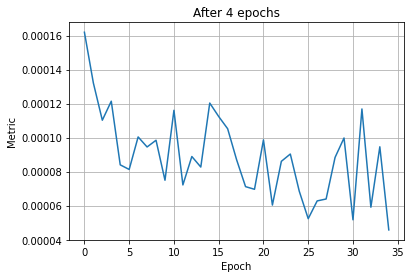

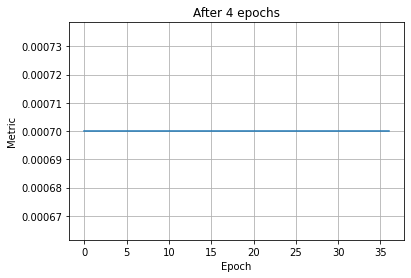

Metric value 4.6e-05
Training has been accomplished for 12.59 minutes


In [522]:
mode = {
    'dark kd'   : {'T' : 10, 'alpha' : 0.85}, 
    'attention' : {'T' : 10, 'alpha' : 0.25},
    'gru'       : {'T' : 10, 'alpha' : 0.75}
}

val_model = train(model, opt, config, 15, history, exp_logger, base_model_qat, None, mode)

In [523]:
tt = copy.deepcopy(model)

> Here we used some tricks to remove equalizers from model, which might appear to be partially compatible with current version of model ('base' mode asks for RNN, not GRU). It can be easilly fixed if needed.

In [ ]:
tft = torch.load('rnn_two_two')
tft.pop('equalizer_rnn_2.weight')
tft.pop('equalizer_rnn_2.bias')
tft.pop('equalizer_rnn_1.weight')
tft.pop('equalizer_rnn_1.bias')
tft.pop('equalizer.weight')
tft.pop('equalizer.bias')

In [813]:
check = CRNN(config, mode='base', qat=True).to(config.device)
check.gru = nn.RNN(
                input_size=check.conv_out_frequency * config.cnn_out_channels,
                hidden_size=config.hidden_size,
                num_layers=config.gru_num_layers,
                dropout=0.1,
                bidirectional=config.bidirectional,
                batch_first=True
)

train(check, opt, config, 0, history, exp_logger, base_model, 
      [None, None, -1], mode)
clear_output()

check.load_state_dict(tft)

val_check = torch.quantization.convert(check, inplace=False)
qconfig = torch.quantization.per_channel_dynamic_qconfig
qconfig_dict = dict.fromkeys(['attention', nn.Linear, nn.GRU], qconfig)
val_check = torch.quantization.quantize_dynamic(val_check,
                                                    dtype=torch.qint8)
val_check.half()

val_check

CRNN(
  (quant): Quantize(scale=tensor([0.2310], dtype=torch.float16), zero_point=tensor([90]), dtype=torch.quint8)
  (activation): ReLU()
  (conv): QuantizedConv2d(1, 4, kernel_size=(7, 18), stride=(5, 12), scale=0.7383055090904236, zero_point=70)
  (dequant): DeQuantize()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): RNN(28, 29, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=29, out_features=29, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=29, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=29, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

> **compression rate**

In [664]:
get_size_in_megabytes(base_model) / get_size_in_megabytes(val_check)

8.809693918973776

In [730]:
quality_flops.append((4.6e-5, 10.05))
quality_mem.append((4.6e-5, 8.81))

## VIth part. Experiment "What if..?"

> This experiment can be viewed as a precestor of the "Low & everythin". While structured prunning showed himself very dreary in terms of efficiency, we decided to reduce role of knowledge distillations, trying to balance it through rates reduction. Now the model is composed of: 
>
>1. **dark KD** with alpha 0.55
>
>2. **attention KD** with alpha 0.25
>
>3. **QAT** similar to the one before

In [694]:
config = TaskConfig(hidden_size=28, cnn_out_channels=5, kernel_size=(7, 20), stride=(4, 10), gru_num_layers=1)
model = CRNN(config, mode='light', qat=True).to(config.device)

exp_log_dict = {'json' : 'logger_config.json', 'name' : 'experiment_three'}
exp_logger = create_log(exp_log_dict)

exp_logger.info('Experiment model: {0}'.format(model))

Experiment model: CRNN(
  (quant): QuantStub()
  (activation): ReLU()
  (conv): Conv2d(1, 5, kernel_size=(7, 20), stride=(4, 10))
  (dequant): DeQuantStub()
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(45, 28, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=28, out_features=28, bias=True)
      (1): Tanh()
      (2): Linear(in_features=28, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=28, out_features=2, bias=True)
  (equalizer): Linear(in_features=28, out_features=32, bias=True)
)


>**speed rate**

In [488]:
item = melspec_train(next(iter(train_loader))[0])
tmp = copy.deepcopy(model)
tmp.mode = 'base'
attempt = profile(tmp, (item, ))
baseline = profile(base_model, (item, ))
clear_output()
print('Model', attempt)
print('Base Model', baseline)
print('Ratio', baseline[0] / attempt[0])

Model (15683584.0, 7904.0)
Base Model (55382016.0, 25387.0)
Ratio 3.5312091930007834


>**Run !**

In [489]:
opt = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=config.weight_decay
)

mode = {
    'dark kd'   : {'T' : 10, 'alpha' : 0.65}, 
    'attention' : {'T' : 10, 'alpha' : 0.25}
}
history = defaultdict(list)

In [490]:
scheduler_two = lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=0, min_lr=0.0003)
scheduler_one = lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0.0005)

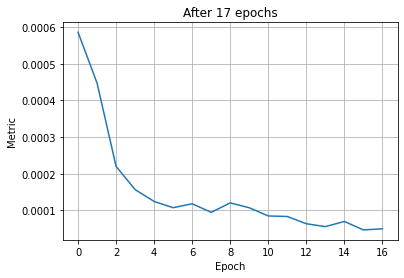

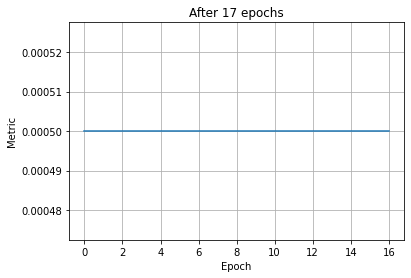

Metric value 5e-05
Training has been accomplished for 53.63 minutes


In [491]:
val_model = train(model, opt, config, 25, history, exp_logger, base_model_qat, 
                  None, mode)

>**compression rate**

In [699]:
model = CRNN(config, mode='base', qat=True).to(config.device)
train(model, opt, config, 0, history, exp_logger, base_model_qat, 
                  None, mode)
clear_output()

dct = torch.load('dark_att_three')
dct.pop('equalizer.weight')
dct.pop('equalizer.bias')

model.load_state_dict(dct)

<All keys matched successfully>

In [701]:
get_size_in_megabytes(base_model) / (get_size_in_megabytes(model))

2.5765541150211333

In [731]:
quality_flops.append((5e-5, 3.5))
quality_mem.append((5e-5, 2.6))

## VIIth part. Experiment "MC KD"

> So, as we approach the bottom of tools usage, let's test if it is possible to reach benchmark on dark KD only. 
>
>1. **dark KD** with alpha 0.75

In [562]:
exp_log_dict = {'json' : 'logger_config.json', 'name' : 'experiment_four'}
exp_logger = create_log(exp_log_dict)

In [799]:
config = TaskConfig(hidden_size=18, cnn_out_channels=5, kernel_size=(5, 20), stride=(4, 10), gru_num_layers=1)
model = CRNN(config, mode='light').to(config.device)

exp_logger.info('Experiment model: {0}'.format(model))

Experiment model: CRNN(
  (conv): Conv2d(1, 5, kernel_size=(5, 20), stride=(4, 10))
  (flatten): Flatten(start_dim=1, end_dim=2)
  (gru): GRU(45, 18, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=18, out_features=18, bias=True)
      (1): Tanh()
      (2): Linear(in_features=18, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=18, out_features=2, bias=True)
  (equalizer): Linear(in_features=18, out_features=32, bias=True)
)


>**speed rate**

In [798]:
model.mode = 'base'
item = melspec_train(next(iter(train_loader))[0])
attempt = profile(model, (item, ))
baseline = profile(base_model, (item, ))

clear_output()
print('Model', attempt)
print('Base Model', baseline)
print('Ratio', baseline[0] / attempt[0])

Model (9771264.0, 4414.0)
Base Model (55382016.0, 25387.0)
Ratio 5.667845633891377


> Sometimes there might be issues if running `load_state_dict` after profile since new attributes are appended to the model. Thusm we recommend to avoid such cases.

In [800]:
model.mode = 'light'

In [ ]:
mode = {
    'dark kd'   : {'T' : 10, 'alpha' : 0.75}
}
history = defaultdict(list)

opt = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=config.weight_decay
)

train(model, opt, config, 25, history, exp_logger, base_model, None, mode)

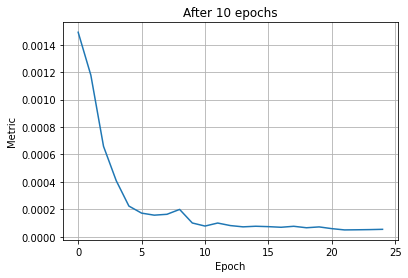

In [805]:
model.load_state_dict(torch.load('dark_kd_four_one'))

<All keys matched successfully>

In [806]:
get_size_in_megabytes(base_model) / (get_size_in_megabytes(model))

4.46263623277812

In [732]:
quality_flops.append((5.4e-5, 5.67))
quality_mem.append((5.4e-5, 4.46))

## VIIIth part. Graphs

In [733]:
x, y = zip(*quality_flops)
x, y

((4.58e-05, 4.6e-05, 5e-05, 5.4e-05), (9.37, 10.05, 3.5, 5.67))

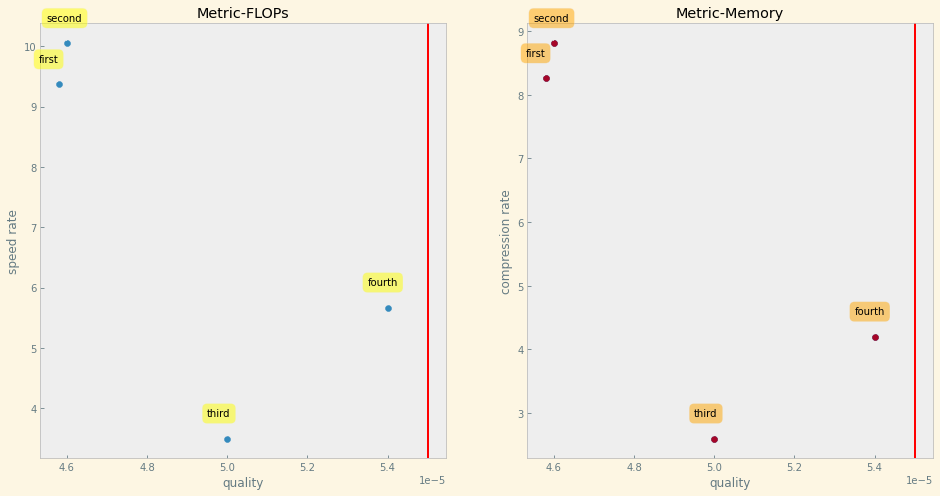

In [758]:
plt.style.use('bmh')
x, y = zip(*quality_flops)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].scatter(x, y)
ax[0].grid()
for label, x, y in zip(['first', 'second', 'third', 'fourth'], x, y):
    ax[0].annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
ax[0].axvline(5.5e-5, c='r')
ax[0].set(xlabel='quality', ylabel='speed rate', title='Metric-FLOPs')

x, y = zip(*quality_mem)
ax[1].scatter(x, y)
ax[1].scatter(x, y)
ax[1].grid()
for label, x, y in zip(['first', 'second', 'third', 'fourth'], x, y):
    ax[1].annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
ax[1].axvline(5.5e-5, c='r')
ax[1].set(xlabel='quality', ylabel='compression rate', title='Metric-Memory')
plt.show()

# Streaming

## Ist part. KWS model

> The architecture implies three key blocks: `LogMelspec` - `CRNN` - Prediction. We create a new streaming object, slightly altering the `LogMelspec` class for the inference mode. Now, the padding is disabled. We also announce `max_window_length` & `step_size` for the purpose of sliding through audio input and restricting class's buffers. By the way, we use three separate buffers:
>
>    1. `audio_buffer` for storing last bins of previous frames' audio in order to create spectrograms, which in turn use sliding windows
>
>    2. `conv_buffer` allows to bound convolution's receptive fields of previous frames and novel one.
>    3. `gru_buffer` checks if the window is full & start the final stage of model.

In [794]:
class KWS(nn.Module):
    def __init__(self, model, config, melspec_val, max_window_length=30, step=16):
        super(KWS, self).__init__()
        self.conv = model.conv
        self.flatten = nn.Flatten(start_dim=1, end_dim=2)
        self.gru = model.gru
        self.attention = Attention(config.hidden_size)
        self.attention.load_state_dict(model.attention.state_dict())
        self.classifier = model.classifier
        
        self.max_window_length = max_window_length
        self.step = step
        self.saved_hid = None
        
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels,
                center=False
            ).to(config.device)
        self.audio_buffer = None
        self.conv_buffer = None
        self.gru_buffer = None
    
        self.device = config.device
        self.counter = 0
    
    def spec_call(self, wave):
         return torch.log(self.melspec(wave.to(self.device)).clamp_(min=1e-9, max=1e9))
    
    def forward(self, wave, verbosity=False):
        return self.process(wave, verbosity)
        
    
    def process(self, wave, verbosity):
        if verbosity:
            if self.audio_buffer is not None: 
                print('audio_buffer', self.audio_buffer.shape, 'wave', wave.shape)
            else:
                print('wave', wave.shape)
            
            
        spectro = self.spec_call(torch.cat([self.audio_buffer, wave], dim=1)) if self.audio_buffer is not None else self.spec_call(wave)
        spectro = spectro.unsqueeze(1)
        self.audio_buffer = wave[:, -400 + 160:]

        if verbosity:
            if self.conv_buffer is not None: 
                print('conv_buffer', self.conv_buffer.shape, 'spectro', spectro.shape)
            else:
                print('spectro', spectro.shape)

            
        input = torch.cat([self.conv_buffer, spectro], dim=-1) if self.conv_buffer is not None else spectro
        if verbosity: print('input', input.shape)
        
        if input.shape[-1] < self.conv.kernel_size[1]:
            self.conv_buffer = input
            return 0
        self.conv_buffer = spectro[:, :, :, -self.conv.kernel_size[1] + self.conv.stride[1]:]
        
        conv_output = self.conv(input)
        flat_output = self.flatten(conv_output).transpose(-1, -2)
        if verbosity: print('conv_out', conv_output.shape)
        
        all_together = torch.cat([self.gru_buffer, flat_output], dim=1) if self.gru_buffer is not None else flat_output

        if all_together.shape[1] < self.max_window_length:
            self.gru_buffer = all_together
            return 0
           
        if verbosity:
            if self.gru_buffer is not None: 
                print('gru_buffer', self.gru_buffer.shape, 'flat', flat_output.shape)
            else:
                print('flat', flat_output.shape)
        
        self.gru_buffer = all_together[:, (self.step + self.conv.kernel_size[1] - self.conv.stride[1]) // self.conv.kernel_size[1]  :]
        gru_output, self.saved_hid = self.gru(all_together, self.saved_hid)
        
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        
        prob = torch.softmax(output, dim=-1)
        if prob[0][1].item() > 0.7: 
            self.saved_hid = torch.zeros(self.saved_hid.shape)
        return prob[0][1].item()

In [795]:
kws = torch.jit.load('third_kws')

In [786]:
torch.inference_mode()

wav, sr = torchaudio.load('glue.wav')
wav = wav.sum(dim=0)

lst = []
waving = torch.split(wav, 160 * 30, 0)
for i in range(wav.shape[0] // (160 * 30)):
    wave = waving[i].to(TaskConfig.device)
    out = kws(wave.unsqueeze(0),)
    lst.append(out)

## IInd part. Graph

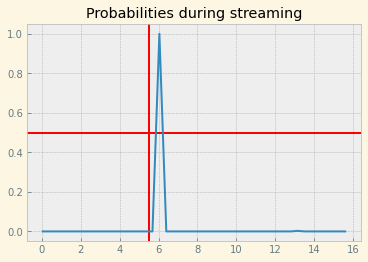

In [796]:
plt.axhline(0.5, c='r')
plt.axvline(5.5, c='r')
plt.plot(np.arange(0, 16, 16 / len(lst)), lst)
plt.title('Probabilities during streaming')
plt.show()